# AB-Testing

![cats](images/cats.jpeg)


Imaginad que somos los cientificos de datos de la empresa de videojuegos Tactile Entertainment. Los desarrolladores del juego Cookie Cats pretenden introducir un cambio en el juego para aumentar la retencion de los jugadores. En cierto nivel del juego los jugadores se encuentran una puerta que les obliga a esperar o a pagar la app. Actualmente la puerta se encuentra en nivel 30 y se pretende pasar al nivel 40, para comprobar la retencion a 1 y 7 dias. Antes de realizar el cambio definitivo en el juego se raliza un test AB.

Los datos estan alojados en `data/cookie_cats.csv`. Nuestro grupo de control sera la version actual `gate_30` y el grupo de tratamiento sera la version `gate_40`. Debemos realizar el test para 1 dia de retencion `retention_1` y para 7 dias `retention_7`.

In [1]:
# librerias

import pandas as pd
import numpy as np

from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from scipy.stats import norm, sem, bernoulli, beta

import pylab as plt

from bayes import *

In [2]:
# datos
df_ori = pd.read_csv('data/cookie_cats.csv')

df = df_ori.copy()

df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,90189.0,4.998412e+06,2.883286e+06,116.0,2512230.0,4995815.0,7496452.0,9999861.0
sum_gamerounds,90189.0,5.187246e+01,1.950509e+02,0.0,5.0,16.0,51.0,49854.0


In [4]:
len(df[df.retention_1 == True]), len(df[df.retention_7 == True])

(40153, 16781)

In [5]:
# transformacion

In [6]:
# Si no ha hecho rondas, no es información relevante porque no ha podido 
# llegar a las puertas ni 30 ni 40

In [7]:
df = df[df.sum_gamerounds != 0]

df.shape, df_ori.shape

((86195, 5), (90189, 5))

In [8]:
# Cogemos el total de jugadores por cada version del jueg
g30_users = df[df.version == 'gate_30'].userid.count()
g40_users = df[df.version == 'gate_40'].userid.count()

g30_users, g40_users

(42763, 43432)

In [9]:
# creamos un dataframe con solo la version y la retención
new_df = df[['version', 'retention_1', 'retention_7']]

new_df.head()

,version,retention_1,retention_7
0,gate_30,False,False
1,gate_30,True,False
2,gate_40,True,False
3,gate_40,False,False
4,gate_40,True,True


In [10]:
# variable para el numero de jugadores retenidos al día o semana siguiente según versión
g30_day_after = new_df[(new_df.version == 'gate_30') & (new_df.retention_1 == True)].version.count()
g40_day_after = new_df[(new_df.version == 'gate_40') & (new_df.retention_1 == True)].version.count()

g30_week_after = new_df[(new_df.version == 'gate_30') & (new_df.retention_7 == True)].version.count()
g40_week_after = new_df[(new_df.version == 'gate_40') & (new_df.retention_7 == True)].version.count()

In [11]:
# testeo para retention_1
inst_ctrl, day_ctrl = g30_users, g30_day_after    # instalados, los que siguieron al día siguiente de la instalación

inst_test, day_test = g40_users, g40_day_after 

CR_ctrl=day_ctrl/inst_ctrl
CR_test=day_test/inst_test

print ('Tasas', CR_ctrl, CR_test)

Tasas 0.46753034165049223 0.46217074967765703


In [12]:
# a prioris

a_C, b_C = 1+day_ctrl, 1+inst_ctrl-day_ctrl

a_T, b_T = 1+day_test, 1+inst_test-day_test


beta_C = beta(a_C, b_C)

beta_T = beta(a_T, b_T)

In [13]:
beta_C.mean(), beta_T.mean()

(0.4675318601660236, 0.4621724915964452)

In [14]:
# diferencia normalizada de las medias de test y control

salto=(beta_T.mean()-beta_C.mean())/beta_C.mean()

salto

-0.011463108776534007

In [15]:
prob=calc_prob(beta_T, beta_C)  # esta funcion es la clave

prob

0.0573555255607238

In [16]:
print (
'''El test aumenta la tasa de conversion en un {:2.2f}%,
con una probabilidad del {:2.2f}%'''
    .format(salto*100, prob*100)
)

El test aumenta la tasa de conversion en un -1.15%,
con una probabilidad del 5.74%


In [17]:
def plot(betas, names, linf=0.452, lsup=0.48):
    x=np.linspace(linf, lsup, 100)
    for f, n in zip(betas, names):
        y=f.pdf(x)
        y_pico=pico(f.args[0], f.args[1])
        y_var=f.var()
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(n, y_pico, y_var))
        plt.yticks([])
    plt.legend()
    plt.show();

0.46753034165049223 0.46217074967765703


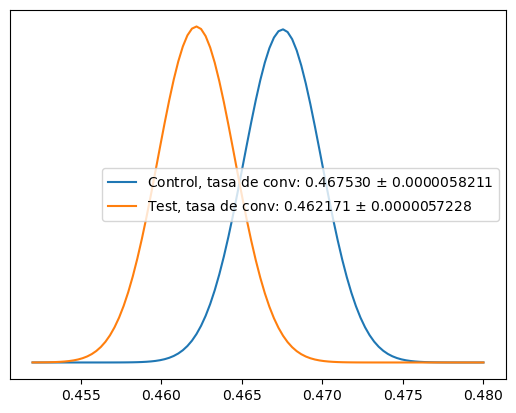

In [18]:
print (CR_ctrl, CR_test)
plot([beta_C, beta_T], ['Control', 'Test'])

In [19]:
# testeo para retention_7
inst_ctrl, day_ctrl = g30_users, g30_week_after    # instalados, los que siguieron al día siguiente de la instalación

inst_test, day_test = g40_users, g40_week_after 

CR_ctrl=day_ctrl/inst_ctrl
CR_test=day_test/inst_test

print ('Tasas', CR_ctrl, CR_test)

Tasas 0.19844257886490657 0.1903205010130779


In [20]:
# a prioris

a_C, b_C = 1+day_ctrl, 1+inst_ctrl-day_ctrl

a_T, b_T = 1+day_test, 1+inst_test-day_test


beta_C = beta(a_C, b_C)

beta_T = beta(a_T, b_T)

In [21]:
beta_C.mean(), beta_T.mean()

(0.19845668186601192, 0.19033476078648065)

In [22]:
# diferencia normalizada de las medias de test y control

salto=(beta_T.mean()-beta_C.mean())/beta_C.mean()

salto

-0.04092541003489513

In [23]:
prob=calc_prob(beta_T, beta_C)  # esta funcion es la clave

prob

0.001293662155996441

In [24]:
print (
'''El test aumenta la tasa de conversion en un {:2.2f}%,
con una probabilidad del {:2.2f}%'''
    .format(salto*100, prob*100)
)

El test aumenta la tasa de conversion en un -4.09%,
con una probabilidad del 0.13%


In [36]:
def plot(betas, names, linf=0.185, lsup=0.205):
    x=np.linspace(linf, lsup, 100)
    for f, n in zip(betas, names):
        y=f.pdf(x)
        y_pico=pico(f.args[0], f.args[1])
        y_var=f.var()
        plt.plot(x, y, label='{}, tasa de conv: {:.6f} $\pm$ {:.10f}'.format(n, y_pico, y_var))
        plt.yticks([])
    plt.legend()
    plt.show();

0.19844257886490657 0.1903205010130779


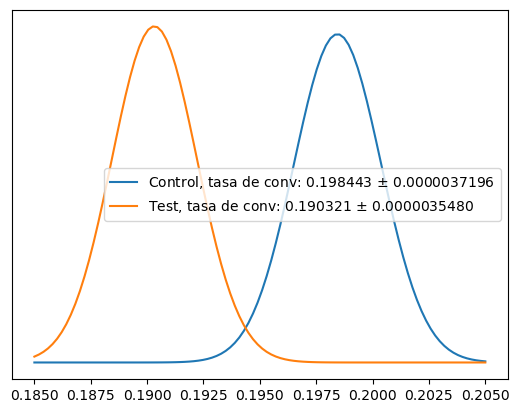

In [37]:
print (CR_ctrl, CR_test)
plot([beta_C, beta_T], ['Control', 'Test'])

In [27]:
# conclusiones
# Explica detalladamente las conclusiones obtenidas de. tu testeo.